I need to make the mass-phase plot from the old mass dependent study, for easier comparison in upcoming presentations. The csv files from this study were from an old version of the `fitsToCsv.C` script, and use a custom `truth` file, so the format of loading the files will be a bit different. The code is copied from my old local analysis scripts

This Input Output study was done:
* In a single t bin $-t$ = [0.1,0.2]
* A single orientation PARA_0
* Comparing Mass Independent fit results to a mass dependent one, that assumed the presence of a $b_1$ and $\rho$

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path    
import sys, os
parent_dir = str(Path().resolve().parents[1])
sys.path.insert(0, parent_dir)
import analysis.scripts.pwa_tools as pwa_tools

Need to load in a fit, bin data, and `scaled.csv`. The `fit_df` is called `with_late_rotation.csv` as it was part of a mini-study. The `scaled` csv contains the fit fractions from a mass dependent fit, but not the phase differences

In [21]:
df = pd.read_csv(f"{parent_dir}/analysis/data/mass_dependant_io/with_late_rotation.csv", index_col="index")
scaled_df = pd.read_csv(f"{parent_dir}/analysis/data/mass_dependant_io/scaled.csv", index_col="index")  

df.drop([8,9], axis="index", inplace=True)
scaled_df.drop([8,9], axis="index", inplace=True)

pwa_tools.wrap_phases(df)
pwa_tools.wrap_phases(scaled_df)

Setup the data for plotting

In [22]:
coherent_sums = pwa_tools.get_coherent_sums(df)
phase_differences = pwa_tools.get_phase_differences(df)
fit_result = df["detected_events"] # these are needed because the columns are actually fit fractions, so this re-scales the value
fit_result_scaled = scaled_df["detected_events"]

mass_range = [1.0, 1.4]
bin_width = 0.05

bin_centers = []    # x-axis for plots
start_edge  = mass_range[0]
while start_edge < mass_range[1]:
    bin_centers.append(start_edge + bin_width/2)
    start_edge += bin_width


Since phase differences can't be obtained from the mass dependent fit, we'll need to grab them from a `.fit` file

In [23]:
import itertools
import math, cmath

def get_names_and_complex_values(file_name: str) -> zip:
    with open(file_name) as f:
        names, complex_values = [], []
        for line1, line2 in itertools.zip_longest(*[f]*2):
            if line2 is None: continue
            if "_im" not in line2: continue
            line1 = line1.split()
            line2 = line2.split()

            names.append(line1[0][:-3])
            complex_values.append(complex(float(line1[-1]), float(line2[-1])))

        names_and_complex_values = zip(names, complex_values)

    return names_and_complex_values

def convert_full_amp_to_eJPmL(full_amp:str)->str:
    if "ImagNegSign" in full_amp or "RealPosSign" in full_amp:
        refl = "m"
    else: 
        refl="p"    
    eJPmL = refl + full_amp[-4:]

    eJPmL = eJPmL[:-1] + eJPmL[-1].capitalize()
    return eJPmL

def breit_wigner(mass0: float, mass: float,
                 width0: float, width: float) -> complex:
    numerator   = complex(math.sqrt(mass0 * width0 / math.pi), 0)
    denominator = complex(mass0**2 - mass**2, -1*mass0 * width)
    return numerator / denominator


names_and_complex_values = get_names_and_complex_values(f"{parent_dir}/analysis/data/mass_dependant_io/best_1.000-1.050.fit")
data_dict = {}

for name, complex_value in names_and_complex_values:
    adjusted_phases = []

    if "1p" not in name and "1m" not in name or "isotropic" in name:
        print("JP not recognized, skipping amplitude: ", name)
        continue

    for mass in bin_centers:
        bw1p = breit_wigner(1.235, mass, 0.142, 0.142)
        bw1m = breit_wigner(1.465, mass, 0.4, 0.4)

        if "1p" in name:   bin_phase = complex_value * bw1p
        elif "1m" in name: bin_phase = complex_value * bw1m

        adjusted_phases.append(cmath.phase(bin_phase))
    
    data_dict[convert_full_amp_to_eJPmL(name)] = adjusted_phases

truth_phase_df = pd.DataFrame(data=data_dict)

JP not recognized, skipping amplitude:  omegapi::Bkgd::isotropic


Now that we have all our data, lets make the plot

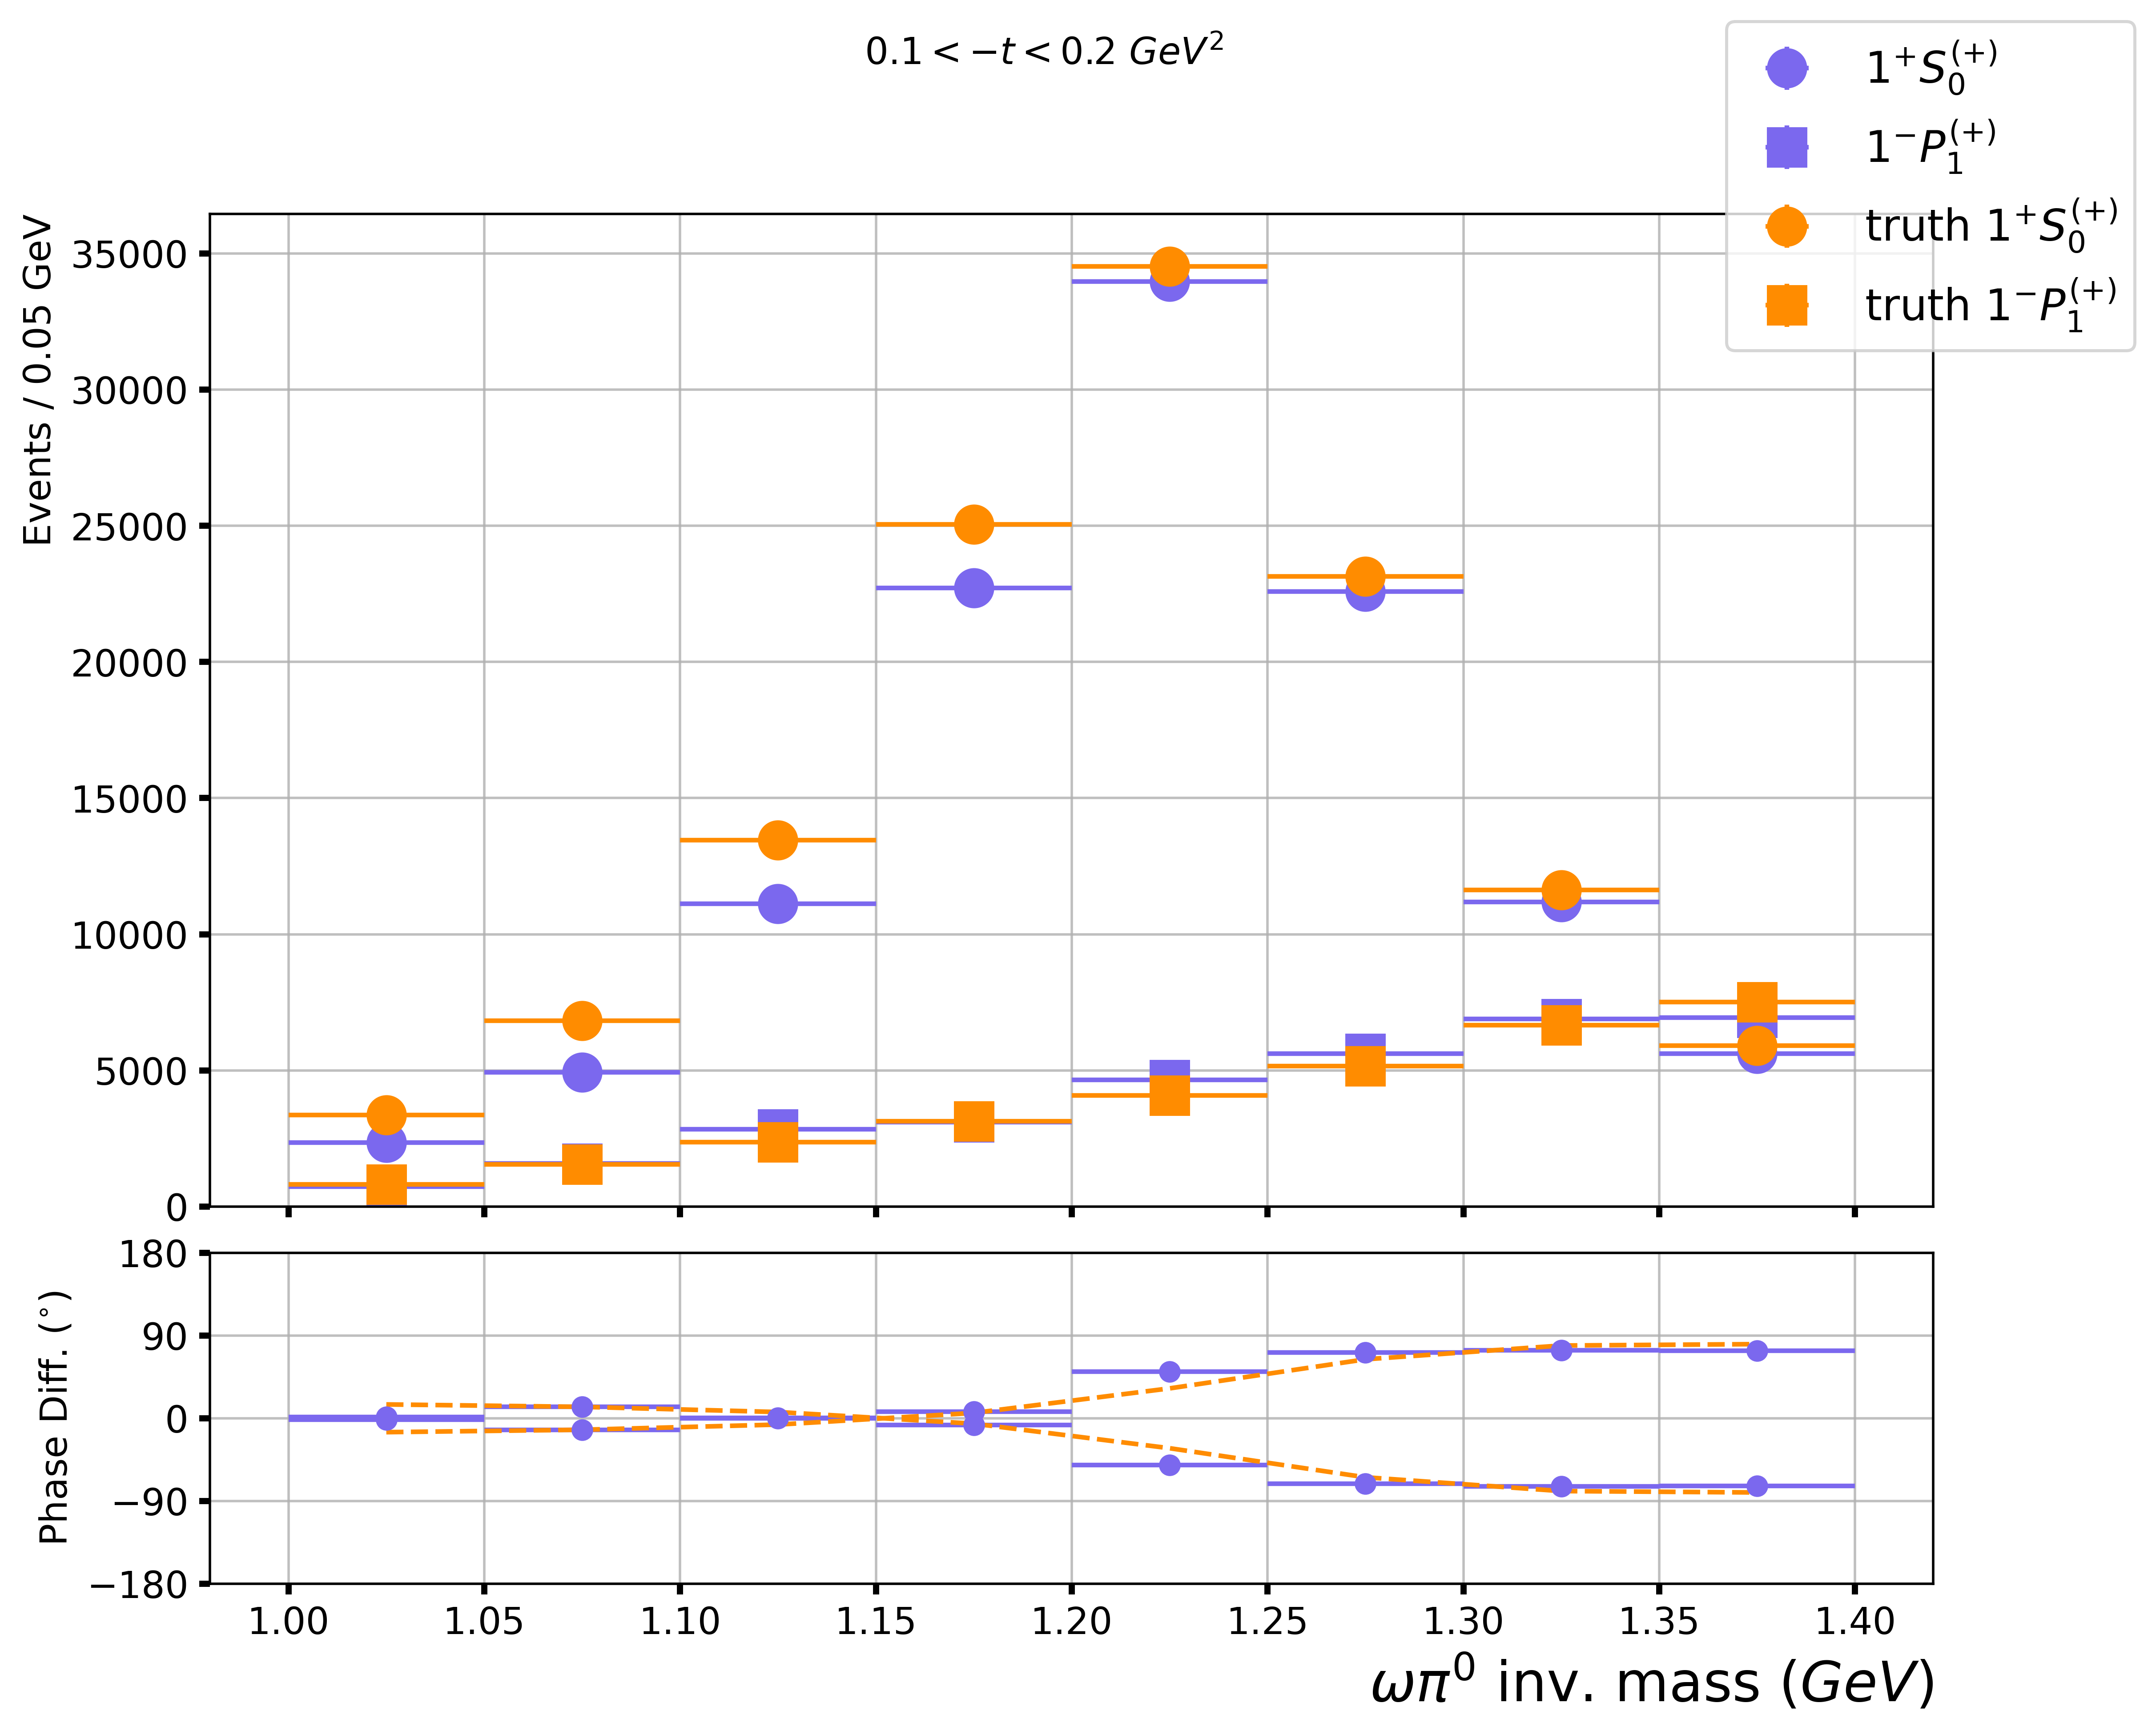

In [28]:
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["figure.dpi"] = 500
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["xtick.major.width"] = 2.0
plt.rcParams["xtick.minor.width"] = 1.8
plt.rcParams["ytick.major.width"] = 2.0
plt.rcParams["ytick.minor.width"] = 1.8
plt.rcParams["lines.markersize"] = 12

fig, axs = plt.subplots(2, 1,sharex=True,
    gridspec_kw={"wspace": 0.0, "hspace": 0.07}, height_ratios=[3, 1]
)
# intensity fit results
axs[0].errorbar(
    bin_centers, 
    df["p1p0S"] * fit_result,
    df["p1p0S"] * fit_result * np.sqrt(np.square(df["p1p0S_err"]/df["p1p0S"]) + np.square(df["detected_events_err"]/fit_result)),
    bin_width/2,
    "o", color="mediumslateblue", label=f"{pwa_tools.convert_amp_name('p1p0S')}",
)
axs[0].errorbar(
    bin_centers, 
    df["p1mpP"] * fit_result,
    df["p1mpP"] * fit_result * np.sqrt(np.square(df["p1mpP_err"]/df["p1mpP"]) + np.square(df["detected_events_err"]/fit_result)),
    bin_width/2,
    "s", color="mediumslateblue", label=f"{pwa_tools.convert_amp_name('p1mpP')}",
)   
# intensity truth info
axs[0].errorbar(
    bin_centers, 
    scaled_df["p1p0S"] * fit_result_scaled,
    scaled_df["p1p0S_err"] * fit_result_scaled,
    bin_width/2,
    "o", color="darkorange", label=f"truth {pwa_tools.convert_amp_name('p1p0S')}",
)
axs[0].errorbar(
    bin_centers, 
    scaled_df["p1mpP"] * fit_result_scaled,
    scaled_df["p1mpP_err"] * fit_result_scaled,
    bin_width/2,
    "s", color="darkorange", label=f"truth {pwa_tools.convert_amp_name('p1mpP')}",
)   

phase_dif = phase_differences[("p1p0S", "p1mpP")]
truth_dif = pwa_tools.wrap_phases(series=(truth_phase_df["p1p0S"] - truth_phase_df["p1mpP"]))

axs[1].errorbar(
    bin_centers,
    df[phase_dif].apply(np.rad2deg),
    df[phase_dif + "_err"].abs().apply(np.rad2deg),
    bin_width / 2,
    linestyle="", marker=".", color="mediumslateblue"
)
axs[1].errorbar(
    bin_centers,
    -df[phase_dif].apply(np.rad2deg),
    df[phase_dif + "_err"].abs().apply(np.rad2deg),
    bin_width / 2,
    linestyle="", marker=".", color="mediumslateblue"
)

axs[1].plot(
    bin_centers,
    truth_dif.apply(np.rad2deg),
    linestyle="--", color="darkorange"
)
axs[1].plot(
    bin_centers,
    -truth_dif.apply(np.rad2deg),
    linestyle="--", color="darkorange"
)

# cosmetics
for ax in axs.reshape(-1):
    ax.grid(True, alpha=0.8)

axs[0].set_ylim(bottom=0.0)
axs[0].set_ylabel(f"Events / {bin_width:.2f} GeV", loc="top", fontsize=12)

axs[1].set_yticks(np.linspace(-180, 180, 5))  # force to be in pi/2 intervals
axs[1].set_ylim([-180, 180])
axs[1].set_ylabel(r"Phase Diff. ($^{\circ}$)", loc="center", fontsize=12)
axs[1].set_xlabel(r"$\omega\pi^0$ inv. mass $(GeV)$", loc="right", fontsize=18)

fig.legend(fontsize=14, loc="upper right")
fig.suptitle(rf"$0.1 < -t < 0.2 ~GeV^2$")
plt.show()